In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
cd drive/MyDrive/Neuromatch_project/

/content/drive/MyDrive/Neuromatch_project


In [ ]:
!pip install torch torchvision matplotlib

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import torchvision
from torchvision import datasets, transforms
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import random

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 363.4/363.4 MB 4.9 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 13.8/13.8 MB 89.2 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 24.6/24.6 MB 67.8 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 883.7/883.7 kB 49.7 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 664.8/664.8 MB 1.5 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 211.5/211.5 MB 5.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 56.3/56.3 MB 14.3 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 127.9/127.9 MB 7.6 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 207.5/207.5 MB 5.4 MB/s eta 0:00:00
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 21.1/21.1 MB 72.8 MB/s eta 0:00:00
  Attempting uninstall: nvidia-nvjitlink-cu12
    Found existing installation: nvidia-nvjitlink-cu12 12.5.82
    Uninstalling nvidia-nvjitlink-cu12-12.5.82:
      Successfully uninstalled nvidia-nvjitlin

## dataset create

VISUAL MEMORY TASK DEMONSTRATION
Generating 10 visual memory samples with 3 distractors...


Creating memory samples: 100%|██████████| 10/10 [01:26<00:00,  8.70s/it]


Dataset created:
  Total samples: 10
  Match trials: 6 (60.0%)
  No-match trials: 4 (40.0%)
  Sequence length: 5 (1 target + 3 distractors + 1 probe)

Dataset Statistics:
  total_samples: 10
  match_trials: 6
  nomatch_trials: 4
  match_percentage: 60.0
  target_digit_distribution: {2: 2, 1: 1, 6: 1, 4: 2, 3: 1, 7: 1, 8: 1, 5: 1}
  probe_digit_distribution: {2: 2, 0: 2, 6: 1, 4: 2, 3: 1, 5: 1, 7: 1}
  sequence_length: 5

Visualizing samples...

Sample 1:
  Target digit: 2
  Probe digit: 2
  Result: MATCH
  Label: 1

Sample 2:
  Target digit: 1
  Probe digit: 0
  Result: NO MATCH
  Label: 0

Sample 3:
  Target digit: 6
  Probe digit: 6
  Result: MATCH
  Label: 1


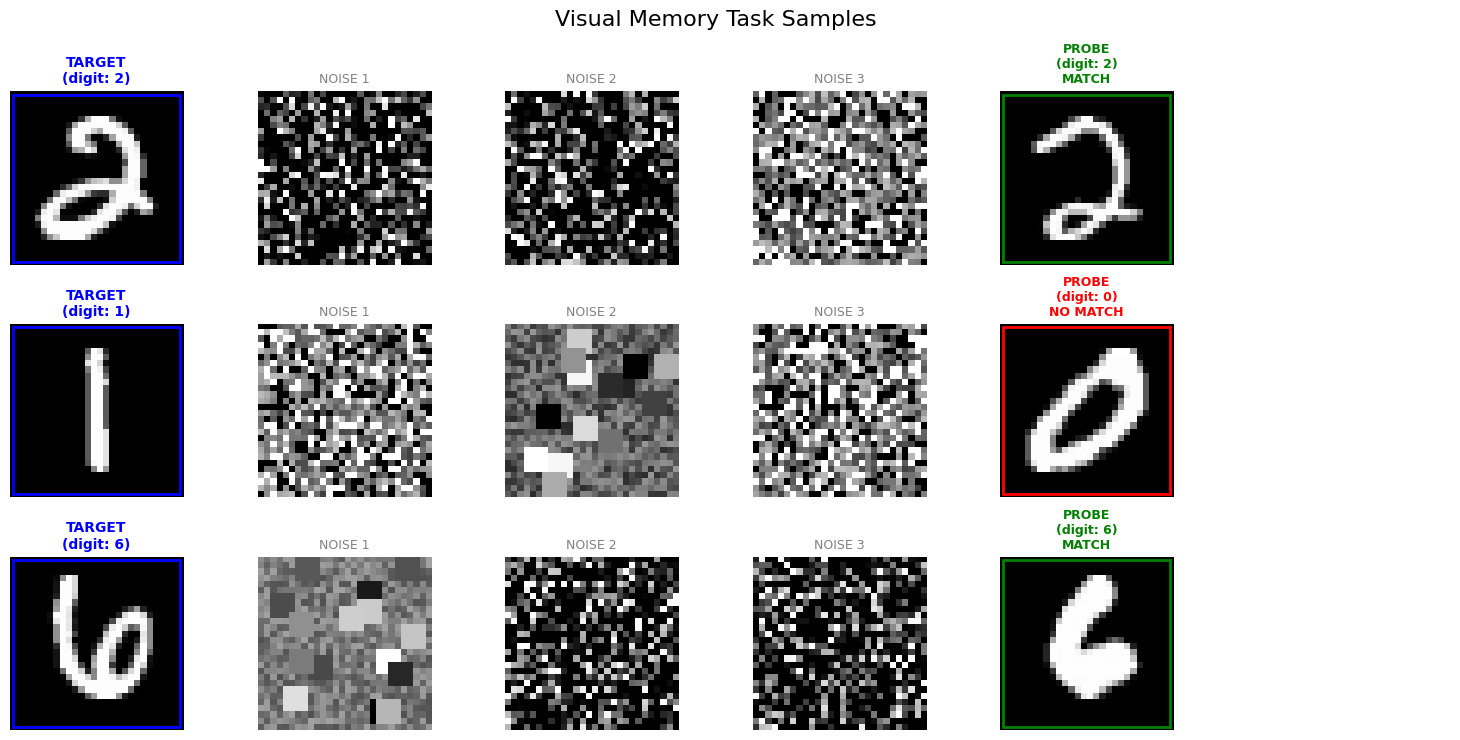


Testing with DataLoader:
  Batch 1:
    Sequences shape: torch.Size([4, 5, 1, 28, 28])
    Labels shape: torch.Size([4])
    Labels: [1, 1, 0, 0]
    Match trials in batch: 2/4
CREATING TRAINING DATASETS
Creating training dataset...
Generating 1000 visual memory samples with 3 distractors...


Creating memory samples: 100%|██████████| 1000/1000 [1:54:33<00:00,  6.87s/it]


Dataset created:
  Total samples: 1000
  Match trials: 484 (48.4%)
  No-match trials: 516 (51.6%)
  Sequence length: 5 (1 target + 3 distractors + 1 probe)

Creating testing dataset...
Generating 300 visual memory samples with 3 distractors...


Creating memory samples: 100%|██████████| 300/300 [05:54<00:00,  1.18s/it]

Dataset created:
  Total samples: 300
  Match trials: 150 (50.0%)
  No-match trials: 150 (50.0%)
  Sequence length: 5 (1 target + 3 distractors + 1 probe)

Datasets ready for training!
Training samples: 1000
Testing samples: 300
Sequence length: 5

READY FOR MODEL TRAINING!
You can now use train_loader and test_loader with your CNN-RNN model!
Each batch contains:
  - sequences: shape [batch_size, 5, 1, 28, 28]
  - labels: shape [batch_size] with values 0 (no-match) or 1 (match)


In [ ]:
transform = transforms.Compose([
    transforms.Resize((28, 28)),
    transforms.Grayscale(),
    transforms.ToTensor(),
    transforms.Normalize((0,), (1,)),
])

mnist_train = datasets.MNIST('./data', train=True, download=True, transform=transform)
mnist_test = datasets.MNIST('./data', train=False, download=True, transform=transform)

class NoiseGenerator:
    @staticmethod
    def gaussian_noise(shape, noise_level=0.5):
        """Generate Gaussian noise image"""
        noise = torch.randn(shape) * noise_level
        return torch.clamp(noise, 0, 1)

    @staticmethod
    def salt_pepper_noise(shape, noise_density=0.3):
        """Generate salt and pepper noise"""
        noise = torch.rand(shape)
        salt_pepper = torch.zeros_like(noise)
        salt_pepper[noise < noise_density/2] = 0
        salt_pepper[noise > 1 - noise_density/2] = 1
        mask = (noise >= noise_density/2) & (noise <= 1 - noise_density/2)
        salt_pepper[mask] = torch.rand(torch.sum(mask).item()) * 0.5 + 0.25
        return salt_pepper

    @staticmethod
    def random_patches(shape, num_patches=10, patch_size=5):
        """Generate random square patches"""
        noise = torch.rand(shape) * 0.3 + 0.35
        h, w = shape[-2:]

        for _ in range(num_patches):
            x = random.randint(0, max(0, w - patch_size))
            y = random.randint(0, max(0, h - patch_size))
            intensity = random.random()
            noise[..., y:y+patch_size, x:x+patch_size] = intensity

        return noise

    @staticmethod
    def scrambled_mnist(mnist_dataset, scramble_intensity=0.8):
        """Create scrambled version of random MNIST digit"""
        random_idx = random.randint(0, len(mnist_dataset) - 1)
        random_image, _ = mnist_dataset[random_idx]

        if random.random() > scramble_intensity:
            return random_image

        img_np = random_image.squeeze().numpy()
        h, w = img_np.shape

        block_size = random.choice([2, 3, 4])
        for i in range(0, h - block_size, block_size):
            for j in range(0, w - block_size, block_size):
                block = img_np[i:i+block_size, j:j+block_size].flatten()
                np.random.shuffle(block)
                img_np[i:i+block_size, j:j+block_size] = block.reshape(block_size, block_size)

        return torch.tensor(img_np).unsqueeze(0).float()


class VisualMemoryDataset(Dataset):

    def __init__(self, mnist_dataset, num_samples=1000, num_distractors=3,
                 noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
                 match_probability=0.5):

        self.mnist_dataset = mnist_dataset
        self.num_samples = num_samples
        self.num_distractors = num_distractors
        self.noise_types = noise_types
        self.match_probability = match_probability
        self.noise_generator = NoiseGenerator()

        # Pre-generate all samples for consistency during training
        print(f"Generating {num_samples} visual memory samples with {num_distractors} distractors...")
        self.samples = []
        self.labels = []
        self.metadata = []  # Store additional info for analysis

        for i in tqdm(range(num_samples), desc="Creating memory samples"):
            sample, label, meta = self._create_memory_sample()
            self.samples.append(sample)
            self.labels.append(label)
            self.metadata.append(meta)

        # Print dataset statistics
        match_count = sum(self.labels)
        print(f"Dataset created:")
        print(f"  Total samples: {num_samples}")
        print(f"  Match trials: {match_count} ({match_count/num_samples*100:.1f}%)")
        print(f"  No-match trials: {num_samples-match_count} ({(num_samples-match_count)/num_samples*100:.1f}%)")
        print(f"  Sequence length: {num_distractors + 2} (1 target + {num_distractors} distractors + 1 probe)")

    def _create_memory_sample(self):

        target_idx = random.randint(0, len(self.mnist_dataset) - 1)
        target_image, target_digit = self.mnist_dataset[target_idx]

        is_match = random.random() < self.match_probability

        if is_match:
            same_digit_indices = [i for i, (_, digit) in enumerate(self.mnist_dataset) if digit == target_digit]
            if target_idx in same_digit_indices:
                same_digit_indices.remove(target_idx)

            if len(same_digit_indices) > 0:
                probe_idx = random.choice(same_digit_indices)
                probe_image, probe_digit = self.mnist_dataset[probe_idx]
            else:
                probe_image, probe_digit = target_image.clone(), target_digit

            label = 1
        else:

            while True:
                probe_idx = random.randint(0, len(self.mnist_dataset) - 1)
                probe_image, probe_digit = self.mnist_dataset[probe_idx]
                if probe_digit != target_digit:
                    break

            label = 0

        sequence = [target_image]

        for i in range(self.num_distractors):
            noise_type = random.choice(self.noise_types)
            noise_image = self._generate_noise_image(target_image.shape, noise_type)
            sequence.append(noise_image)

        sequence.append(probe_image)

        sequence_tensor = torch.stack(sequence)

        metadata = {
            'target_digit': target_digit,
            'probe_digit': probe_digit,
            'is_match': is_match,
            'target_idx': target_idx,
            'probe_idx': probe_idx if not is_match else probe_idx,
            'sequence_length': len(sequence)
        }

        return sequence_tensor, label, metadata

    def _generate_noise_image(self, shape, noise_type):
        """Generate a single noise/distractor image"""
        if noise_type == 'gaussian':
            return self.noise_generator.gaussian_noise(shape, noise_level=0.6)
        elif noise_type == 'salt_pepper':
            return self.noise_generator.salt_pepper_noise(shape, noise_density=0.4)
        elif noise_type == 'patches':
            return self.noise_generator.random_patches(shape, num_patches=15, patch_size=4)
        elif noise_type == 'scrambled':
            return self.noise_generator.scrambled_mnist(self.mnist_dataset, scramble_intensity=0.8)
        else:
            # Default to gaussian noise
            return self.noise_generator.gaussian_noise(shape, noise_level=0.5)

    def __len__(self):
        return len(self.samples)

    def __getitem__(self, idx):
        """
        Returns:
            sequence: Tensor of shape [seq_len, 1, 28, 28]
                     [target, distractor1, distractor2, ..., probe]
            label: Integer (1 for match, 0 for no-match)
        """
        return self.samples[idx], self.labels[idx]

    def get_sample_with_metadata(self, idx):
        """Get sample with additional metadata for analysis"""
        return self.samples[idx], self.labels[idx], self.metadata[idx]

    def get_statistics(self):
        """Get dataset statistics"""
        match_count = sum(self.labels)
        total = len(self.labels)

        # Count digits used
        target_digits = [meta['target_digit'] for meta in self.metadata]
        probe_digits = [meta['probe_digit'] for meta in self.metadata]

        from collections import Counter
        target_counter = Counter(target_digits)
        probe_counter = Counter(probe_digits)

        return {
            'total_samples': total,
            'match_trials': match_count,
            'nomatch_trials': total - match_count,
            'match_percentage': match_count / total * 100,
            'target_digit_distribution': dict(target_counter),
            'probe_digit_distribution': dict(probe_counter),
            'sequence_length': self.num_distractors + 2
        }


def demonstrate_visual_memory_task():
    """Demonstrate how the visual memory task works"""

    print("="*60)
    print("VISUAL MEMORY TASK DEMONSTRATION")
    print("="*60)

    # Create a small dataset for demonstration
    demo_dataset = VisualMemoryDataset(
        mnist_train,
        num_samples=10,  # Small for demo
        num_distractors=3,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Show statistics
    stats = demo_dataset.get_statistics()
    print(f"\nDataset Statistics:")
    for key, value in stats.items():
        print(f"  {key}: {value}")

    # Visualize some samples
    print(f"\nVisualizing samples...")
    visualize_memory_samples(demo_dataset, num_samples=3)

    # Test with DataLoader
    print(f"\nTesting with DataLoader:")
    dataloader = DataLoader(demo_dataset, batch_size=4, shuffle=True)

    for batch_idx, (sequences, labels) in enumerate(dataloader):
        print(f"  Batch {batch_idx + 1}:")
        print(f"    Sequences shape: {sequences.shape}")  # [batch_size, seq_len, 1, 28, 28]
        print(f"    Labels shape: {labels.shape}")        # [batch_size]
        print(f"    Labels: {labels.tolist()}")
        print(f"    Match trials in batch: {(labels == 1).sum().item()}/{len(labels)}")
        break

def visualize_memory_samples(dataset, num_samples=5):
    """Visualize memory task samples with detailed annotations"""

    fig, axes = plt.subplots(num_samples, 6, figsize=(15, num_samples * 2.5))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Visual Memory Task Samples', fontsize=16)

    for i in range(num_samples):
        sequence, label, metadata = dataset.get_sample_with_metadata(i)
        seq_len = sequence.shape[0]

        target_digit = metadata['target_digit']
        probe_digit = metadata['probe_digit']
        is_match = metadata['is_match']

        print(f"\nSample {i+1}:")
        print(f"  Target digit: {target_digit}")
        print(f"  Probe digit: {probe_digit}")
        print(f"  Result: {'MATCH' if is_match else 'NO MATCH'}")
        print(f"  Label: {label}")

        # Display sequence
        for j in range(min(seq_len, 6)):  # Show up to 6 images
            ax = axes[i, j]
            img = sequence[j].squeeze().numpy()
            ax.imshow(img, cmap='gray')
            ax.axis('off')

            if j == 0:
                # Target image
                ax.set_title(f'TARGET\n(digit: {target_digit})',
                           fontweight='bold', color='blue', fontsize=10)
                ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                         edgecolor='blue', linewidth=2))
            elif j == seq_len - 1:
                # Probe image
                match_text = 'MATCH' if is_match else 'NO MATCH'
                color = 'green' if is_match else 'red'
                ax.set_title(f'PROBE\n(digit: {probe_digit})\n{match_text}',
                           fontweight='bold', color=color, fontsize=9)
                ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                         edgecolor=color, linewidth=2))
            else:
                # Distractor image
                ax.set_title(f'NOISE {j}', color='gray', fontsize=9)

        # Hide unused subplots
        for j in range(seq_len, 6):
            axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()

def create_datasets_for_training(train_size=3000, test_size=1000, num_distractors=3):
    """Create properly sized datasets for actual training"""

    print("="*60)
    print("CREATING TRAINING DATASETS")
    print("="*60)

    # Training dataset
    print("Creating training dataset...")
    train_memory_dataset = VisualMemoryDataset(
        mnist_train,
        num_samples=train_size,
        num_distractors=num_distractors,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Testing dataset
    print("\nCreating testing dataset...")
    test_memory_dataset = VisualMemoryDataset(
        mnist_test,
        num_samples=test_size,
        num_distractors=num_distractors,
        noise_types=['gaussian', 'salt_pepper', 'patches', 'scrambled'],
        match_probability=0.5
    )

    # Create DataLoaders
    train_loader = DataLoader(train_memory_dataset, batch_size=32, shuffle=True)
    test_loader = DataLoader(test_memory_dataset, batch_size=32, shuffle=False)

    print(f"\nDatasets ready for training!")
    print(f"Training samples: {len(train_memory_dataset)}")
    print(f"Testing samples: {len(test_memory_dataset)}")
    print(f"Sequence length: {num_distractors + 2}")

    return train_memory_dataset, test_memory_dataset, train_loader, test_loader


if __name__ == "__main__":
    demonstrate_visual_memory_task()

    train_dataset, test_dataset, train_loader, test_loader = create_datasets_for_training(
        train_size=1000,
        test_size=300,
        num_distractors=3
    )

    print(f"\n" + "="*60)
    print("READY FOR MODEL TRAINING!")
    print("="*60)
    print("You can now use train_loader and test_loader with your CNN-RNN model!")
    print(f"Each batch contains:")
    print(f"  - sequences: shape [batch_size, {3+2}, 1, 28, 28]")
    print(f"  - labels: shape [batch_size] with values 0 (no-match) or 1 (match)")

## load dataset and create data loader function

In [ ]:
def create_dataloaders_from_datasets(train_dataset, test_dataset, batch_size=32):
    """Create DataLoaders from your loaded datasets"""

    from torch.utils.data import DataLoader

    train_loader = DataLoader(
        train_dataset,
        batch_size=batch_size,
        shuffle=True,
        drop_last=True  # For consistent batch sizes
    )

    test_loader = DataLoader(
        test_dataset,
        batch_size=batch_size,
        shuffle=False,
        drop_last=False
    )

    print(f"✅ DataLoaders created!")
    print(f"Training: {len(train_loader)} batches of size {batch_size}")
    print(f"Test: {len(test_loader)} batches of size {batch_size}")

    return train_loader, test_loader

def load_datasets_simple(train_path, test_path):
    """Simple way to load your saved datasets"""

    print(f"Loading datasets...")
    print(f"Training: {train_path}")
    print(f"Test: {test_path}")

    # Check if files exist
    if not os.path.exists(train_path):
        raise FileNotFoundError(f"Training dataset not found: {train_path}")
    if not os.path.exists(test_path):
        raise FileNotFoundError(f"Test dataset not found: {test_path}")

    # Load training dataset
    print("Loading training dataset...")
    with open(train_path, 'rb') as f:
        train_data = pickle.load(f)

    # Load test dataset
    print("Loading test dataset...")
    with open(test_path, 'rb') as f:
        test_data = pickle.load(f)

    # Create dataset objects
    train_dataset = SimpleVisualMemoryDataset(train_data)
    test_dataset = SimpleVisualMemoryDataset(test_data)

    # Print info
    print(f"✅ Datasets loaded successfully!")
    print(f"Training: {len(train_dataset)} samples")
    print(f"Test: {len(test_dataset)} samples")
    print(f"Distractors: {train_dataset.num_distractors}")
    print(f"Creation time: {train_data.get('creation_time', 'Unknown')}")

    return train_dataset, test_dataset

## load dataset

In [ ]:
train_dataset, test_dataset = load_datasets_simple(train_path, test_path) ## change path to the dataset path
train_loader, test_loader = create_dataloaders_from_datasets(train_dataset, test_dataset)

## visual function

In [ ]:
def plot_training_history(train_losses, train_accs, test_losses, test_accs,
                         train_match_accs, train_nomatch_accs,
                         test_match_accs, test_nomatch_accs):
    """Plot comprehensive training history"""

    epochs = range(1, len(train_losses) + 1)

    fig, axes = plt.subplots(2, 2, figsize=(15, 10))
    fig.suptitle('Visual Memory Task Training History', fontsize=16)

    # Loss plot
    axes[0, 0].plot(epochs, train_losses, 'b-', label='Train Loss', marker='o')
    axes[0, 0].plot(epochs, test_losses, 'r-', label='Test Loss', marker='s')
    axes[0, 0].set_title('Loss Over Time')
    axes[0, 0].set_xlabel('Epoch')
    axes[0, 0].set_ylabel('Loss')
    axes[0, 0].legend()
    axes[0, 0].grid(True, alpha=0.3)

    # Overall accuracy plot
    axes[0, 1].plot(epochs, train_accs, 'b-', label='Train Accuracy', marker='o')
    axes[0, 1].plot(epochs, test_accs, 'r-', label='Test Accuracy', marker='s')
    axes[0, 1].set_title('Overall Accuracy')
    axes[0, 1].set_xlabel('Epoch')
    axes[0, 1].set_ylabel('Accuracy (%)')
    axes[0, 1].legend()
    axes[0, 1].grid(True, alpha=0.3)

    # Match trial accuracy
    axes[1, 0].plot(epochs, train_match_accs, 'g-', label='Train Match', marker='o')
    axes[1, 0].plot(epochs, test_match_accs, 'darkgreen', label='Test Match', marker='s')
    axes[1, 0].set_title('Match Trial Accuracy')
    axes[1, 0].set_xlabel('Epoch')
    axes[1, 0].set_ylabel('Accuracy (%)')
    axes[1, 0].legend()
    axes[1, 0].grid(True, alpha=0.3)

    # No-match trial accuracy
    axes[1, 1].plot(epochs, train_nomatch_accs, 'orange', label='Train No-Match', marker='o')
    axes[1, 1].plot(epochs, test_nomatch_accs, 'red', label='Test No-Match', marker='s')
    axes[1, 1].set_title('No-Match Trial Accuracy')
    axes[1, 1].set_xlabel('Epoch')
    axes[1, 1].set_ylabel('Accuracy (%)')
    axes[1, 1].legend()
    axes[1, 1].grid(True, alpha=0.3)

    plt.tight_layout()
    plt.show()

def plot_confusion_matrix(predictions, targets, epoch):
    """Plot confusion matrix"""
    cm = confusion_matrix(targets, predictions)

    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues',
                xticklabels=['No Match', 'Match'],
                yticklabels=['No Match', 'Match'])
    plt.title(f'Confusion Matrix - Epoch {epoch}')
    plt.xlabel('Predicted Label')
    plt.ylabel('True Label')
    plt.show()

    # Print classification report
    print(f"\nClassification Report - Epoch {epoch}:")
    print(classification_report(targets, predictions,
                              target_names=['No Match', 'Match']))

def visualize_model_predictions(model, test_dataset, device, num_samples=6):
    """Visualize model predictions on test samples"""
    model.eval()

    fig, axes = plt.subplots(num_samples, 6, figsize=(15, num_samples * 2.5))
    if num_samples == 1:
        axes = axes.reshape(1, -1)

    fig.suptitle('Model Predictions on Test Samples', fontsize=16)

    indices = np.random.choice(len(test_dataset), num_samples, replace=False)

    with torch.no_grad():
        for i, idx in enumerate(indices):
            sequence, true_label, metadata = test_dataset.get_sample_with_metadata(idx)

            # Get model prediction
            sequence_batch = sequence.unsqueeze(0).to(device)  # Add batch dimension
            output = model(sequence_batch)
            probabilities = F.softmax(output, dim=1)
            predicted_label = output.argmax(1).item()
            confidence = probabilities[0][predicted_label].item()

            # Get attention weights
            try:
                attention_weights = model.get_attention_weights(sequence_batch)[0].cpu().numpy()
            except:
                attention_weights = np.ones(sequence.shape[0]) / sequence.shape[0]  # Uniform if error

            seq_len = sequence.shape[0]
            target_digit = metadata['target_digit']
            probe_digit = metadata['probe_digit']

            print(f"\nSample {i+1}:")
            print(f"  Target: {target_digit}, Probe: {probe_digit}")
            print(f"  True: {'MATCH' if true_label == 1 else 'NO MATCH'}")
            print(f"  Predicted: {'MATCH' if predicted_label == 1 else 'NO MATCH'} (conf: {confidence:.3f})")
            print(f"  Attention weights: {attention_weights}")

            # Display sequence
            for j in range(min(seq_len, 6)):
                ax = axes[i, j]
                img = sequence[j].squeeze().numpy()
                ax.imshow(img, cmap='gray')
                ax.axis('off')

                # Add attention-based border
                alpha = attention_weights[j] if j < len(attention_weights) else 0.1
                border_width = int(alpha * 5) + 1

                if j == 0:
                    ax.set_title(f'TARGET\n(att: {alpha:.2f})', color='blue', fontweight='bold')
                    ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                             edgecolor='blue', linewidth=border_width))
                elif j == seq_len - 1:
                    color = 'green' if predicted_label == true_label else 'red'
                    pred_text = 'MATCH' if predicted_label == 1 else 'NO MATCH'
                    ax.set_title(f'PROBE\n{pred_text}\n(att: {alpha:.2f})',
                               color=color, fontweight='bold')
                    ax.add_patch(plt.Rectangle((0, 0), 27, 27, fill=False,
                                             edgecolor=color, linewidth=border_width))
                else:
                    ax.set_title(f'NOISE {j}\n(att: {alpha:.2f})', color='gray')

            # Hide unused subplots
            for j in range(seq_len, 6):
                axes[i, j].axis('off')

    plt.tight_layout()
    plt.show()


## mean function

In [ ]:
# Import necessary libraries
import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm
import time
import os
from sklearn.metrics import confusion_matrix, classification_report
import seaborn as sns

# Set device
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

class SimpleCNN(nn.Module):
    def __init__(self, num_classes=10):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(1, 32, kernel_size=3, padding=1)
        self.conv2 = nn.Conv2d(32, 64, kernel_size=3, padding=1)
        self.conv3 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.dropout1 = nn.Dropout(0.25)
        self.dropout2 = nn.Dropout(0.5)
        self.fc1 = nn.Linear(128 * 7 * 7, 512)
        self.fc2 = nn.Linear(512, num_classes)

    def forward(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))
        x = self.dropout2(x)
        x = self.fc2(x)
        return x

    def extract_features(self, x):
        x = F.relu(self.conv1(x))
        x = self.pool(x)
        x = F.relu(self.conv2(x))
        x = self.pool(x)
        x = F.relu(self.conv3(x))
        x = self.dropout1(x)
        x = x.view(x.size(0), -1)
        x = F.relu(self.fc1(x))

        return x

class CNNFeatureExtractor(nn.Module):
    def __init__(self, pretrained_cnn_path, feature_dim=512):
        super(CNNFeatureExtractor, self).__init__()

        self.cnn = SimpleCNN()
        self.cnn.load_state_dict(torch.load(pretrained_cnn_path, map_location=device))

        for param in self.cnn.parameters():
            param.requires_grad = False

        self.cnn.eval()
        self.feature_dim = feature_dim

    def forward(self, x):
        with torch.no_grad():
            features = self.cnn.extract_features(x)
        return features


class VisualMemoryModel(nn.Module):
    def __init__(self, pretrained_cnn_path, rnn_hidden_dim=256,
                 projection_dim=128, rnn_type='LSTM', num_layers=2, dropout=0.3):
        super(VisualMemoryModel, self).__init__()

        self.cnn_features = CNNFeatureExtractor(pretrained_cnn_path)
        cnn_feature_dim = self.cnn_features.feature_dim

        self.feature_projection = nn.Sequential(
            nn.Linear(cnn_feature_dim, projection_dim * 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(projection_dim * 2, projection_dim),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5)
        )

        self.rnn_type = rnn_type
        if rnn_type == 'LSTM':
            self.rnn = nn.LSTM(
                projection_dim, rnn_hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )
        elif rnn_type == 'GRU':
            self.rnn = nn.GRU(
                projection_dim, rnn_hidden_dim,
                num_layers=num_layers,
                batch_first=True,
                dropout=dropout if num_layers > 1 else 0,
                bidirectional=False
            )

        self.memory_classifier = nn.Sequential(
            nn.Linear(rnn_hidden_dim, rnn_hidden_dim // 2),
            nn.ReLU(),
            nn.Dropout(dropout),
            nn.Linear(rnn_hidden_dim // 2, 64),
            nn.ReLU(),
            nn.Dropout(dropout * 0.5),
            nn.Linear(64, 2)
        )

        self.rnn_hidden_dim = rnn_hidden_dim
        self.num_layers = num_layers
        self.projection_dim = projection_dim

    def forward(self, x):
        batch_size, seq_len = x.size(0), x.size(1)
        x = x.view(batch_size * seq_len, *x.shape[2:])
        cnn_features = self.cnn_features(x)
        projected_features = self.feature_projection(cnn_features)
        projected_features = projected_features.view(batch_size, seq_len, -1)

        if self.rnn_type == 'LSTM':
            rnn_output, (hidden, cell) = self.rnn(projected_features)
        else:
            rnn_output, hidden = self.rnn(projected_features)

        final_output = rnn_output[:, -1, :]
        logits = self.memory_classifier(final_output)
        return logits

    def get_attention_weights(self, x):
        """Get attention-like weights to see what the model focuses on"""
        batch_size, seq_len = x.size(0), x.size(1)

        x = x.view(batch_size * seq_len, *x.shape[2:])
        cnn_features = self.cnn_features(x)
        projected_features = self.feature_projection(cnn_features)
        projected_features = projected_features.view(batch_size, seq_len, -1)

        if self.rnn_type == 'LSTM':
            rnn_output, _ = self.rnn(projected_features)
        else:
            rnn_output, _ = self.rnn(projected_features)

        final_state = rnn_output[:, -1:, :]  # [batch_size, 1, hidden_dim]
        attention_scores = torch.bmm(rnn_output, final_state.transpose(1, 2))  # [batch_size, seq_len, 1]
        attention_weights = F.softmax(attention_scores.squeeze(-1), dim=1)  # [batch_size, seq_len]
        return attention_weights

def train_memory_model(model, train_loader, criterion, optimizer, device, epoch):

    model.train()
    model.cnn_features.eval()

    running_loss = 0.0
    correct = 0
    total = 0
    match_correct = 0
    match_total = 0
    nomatch_correct = 0
    nomatch_total = 0

    train_bar = tqdm(train_loader, desc=f'Epoch {epoch} Training')

    for batch_idx, (sequences, targets) in enumerate(train_bar):
        sequences, targets = sequences.to(device), targets.to(device)
        optimizer.zero_grad()
        outputs = model(sequences)
        loss = criterion(outputs, targets)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm=1.0)
        optimizer.step()


        running_loss += loss.item()
        _, predicted = outputs.max(1)
        total += targets.size(0)
        correct += predicted.eq(targets).sum().item()

        # Separate accuracy for match vs no-match
        match_mask = (targets == 1)
        nomatch_mask = (targets == 0)

        if match_mask.sum() > 0:
            match_correct += predicted[match_mask].eq(targets[match_mask]).sum().item()
            match_total += match_mask.sum().item()

        if nomatch_mask.sum() > 0:
            nomatch_correct += predicted[nomatch_mask].eq(targets[nomatch_mask]).sum().item()
            nomatch_total += nomatch_mask.sum().item()


        train_bar.set_postfix({
            'Loss': f'{running_loss/(batch_idx+1):.4f}',
            'Acc': f'{100.*correct/total:.2f}%',
            'M': f'{100.*match_correct/max(match_total,1):.1f}%',
            'NM': f'{100.*nomatch_correct/max(nomatch_total,1):.1f}%'
        })

    epoch_loss = running_loss / len(train_loader)
    epoch_acc = 100. * correct / total
    match_acc = 100. * match_correct / max(match_total, 1)
    nomatch_acc = 100. * nomatch_correct / max(nomatch_total, 1)

    return epoch_loss, epoch_acc, match_acc, nomatch_acc

def test_memory_model(model, test_loader, criterion, device, epoch):
    """Test the model"""
    model.eval()
    test_loss = 0.0
    correct = 0
    total = 0
    match_correct = 0
    match_total = 0
    nomatch_correct = 0
    nomatch_total = 0

    all_predictions = []
    all_targets = []

    with torch.no_grad():
        test_bar = tqdm(test_loader, desc=f'Epoch {epoch} Testing')

        for sequences, targets in test_bar:
            sequences, targets = sequences.to(device), targets.to(device)

            outputs = model(sequences)
            loss = criterion(outputs, targets)

            test_loss += loss.item()
            _, predicted = outputs.max(1)
            total += targets.size(0)
            correct += predicted.eq(targets).sum().item()

            all_predictions.extend(predicted.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

            match_mask = (targets == 1)
            nomatch_mask = (targets == 0)

            if match_mask.sum() > 0:
                match_correct += predicted[match_mask].eq(targets[match_mask]).sum().item()
                match_total += match_mask.sum().item()

            if nomatch_mask.sum() > 0:
                nomatch_correct += predicted[nomatch_mask].eq(targets[nomatch_mask]).sum().item()
                nomatch_total += nomatch_mask.sum().item()

            test_bar.set_postfix({
                'Loss': f'{test_loss/len(test_loader):.4f}',
                'Acc': f'{100.*correct/total:.2f}%'
            })

    epoch_loss = test_loss / len(test_loader)
    epoch_acc = 100. * correct / total
    match_acc = 100. * match_correct / max(match_total, 1)
    nomatch_acc = 100. * nomatch_correct / max(nomatch_total, 1)

    return epoch_loss, epoch_acc, match_acc, nomatch_acc, all_predictions, all_targets


Using device: cuda


In [ ]:
def train_visual_memory_model(train_loader, test_loader, test_dataset,
                             pretrained_cnn_path, num_epochs=15,
                             learning_rate=0.001, save_path='visual_memory_model.pth'):

    print("="*60)
    print("VISUAL MEMORY TASK TRAINING")
    print("="*60)

    model = VisualMemoryModel(
        pretrained_cnn_path=pretrained_cnn_path,
        rnn_hidden_dim=256,
        projection_dim=128,
        rnn_type='GRU',
        num_layers=2,
        dropout=0.3
    ).to(device)

    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(
        filter(lambda p: p.requires_grad, model.parameters()),
        lr=learning_rate,
        weight_decay=1e-4
    )

    scheduler = optim.lr_scheduler.ReduceLROnPlateau(
        optimizer, mode='max', factor=0.5, patience=3, verbose=True
    )

    train_losses = []
    train_accs = []
    test_losses = []
    test_accs = []
    train_match_accs = []
    train_nomatch_accs = []
    test_match_accs = []
    test_nomatch_accs = []

    best_test_acc = 0.0
    best_model_state = None

    print(f"\nStarting training for {num_epochs} epochs...")
    start_time = time.time()

    for epoch in range(1, num_epochs + 1):
        print(f"\nEpoch {epoch}/{num_epochs}")
        print("-" * 40)

        train_loss, train_acc, train_match_acc, train_nomatch_acc = train_memory_model(
            model, train_loader, criterion, optimizer, device, epoch
        )

        test_loss, test_acc, test_match_acc, test_nomatch_acc, predictions, targets = test_memory_model(
            model, test_loader, criterion, device, epoch
        )

        scheduler.step(test_acc)

        train_losses.append(train_loss)
        train_accs.append(train_acc)
        test_losses.append(test_loss)
        test_accs.append(test_acc)
        train_match_accs.append(train_match_acc)
        train_nomatch_accs.append(train_nomatch_acc)
        test_match_accs.append(test_match_acc)
        test_nomatch_accs.append(test_nomatch_acc)

        if test_acc > best_test_acc:
            best_test_acc = test_acc
            best_model_state = model.state_dict().copy()

        print(f"Train - Loss: {train_loss:.4f}, Acc: {train_acc:.2f}%, "
              f"Match: {train_match_acc:.2f}%, No-Match: {train_nomatch_acc:.2f}%")
        print(f"Test  - Loss: {test_loss:.4f}, Acc: {test_acc:.2f}%, "
              f"Match: {test_match_acc:.2f}%, No-Match: {test_nomatch_acc:.2f}%")

        if epoch % 5 == 0:
            plot_confusion_matrix(predictions, targets, epoch)

    training_time = time.time() - start_time
    print(f"\nTraining completed in {training_time:.1f} seconds")

## uncommen if you want to save the model

    #torch.save(best_model_state, save_path)
    #print(f"Best model saved to {save_path} (Test Acc: {best_test_acc:.2f}%)")

    #plot_training_history(train_losses, train_accs, test_losses, test_accs,
    #                     train_match_accs, train_nomatch_accs,
    #                     test_match_accs, test_nomatch_accs)

    #model.load_state_dict(best_model_state)
    #visualize_model_predictions(model, test_dataset, device, num_samples=1)

    print(f"\n" + "="*60)
    print("FINAL RESULTS")
    print("="*60)
    print(f"Best Test Accuracy: {best_test_acc:.2f}%")
    print(f"Final Test Match Accuracy: {test_match_accs[-1]:.2f}%")
    print(f"Final Test No-Match Accuracy: {test_nomatch_accs[-1]:.2f}%")
    print(f"Training Time: {training_time:.1f} seconds")

    return model, {
        'train_losses': train_losses,
        'train_accs': train_accs,
        'test_losses': test_losses,
        'test_accs': test_accs,
        'best_test_acc': best_test_acc
    }


/usr/local/lib/python3.11/dist-packages/torch/optim/lr_scheduler.py:62: UserWarning: The verbose parameter is deprecated. Please use get_last_lr() to access the learning rate.
  warnings.warn(


Visual Memory Task Training Script
Make sure you have:
1. Pretrained CNN model: 'mnist_cnn_model.pth'
2. Visual memory datasets loaded

To use this script:
1. Load your datasets using load_saved_datasets()
2. Call train_visual_memory_model() with your data loaders
VISUAL MEMORY TASK TRAINING

Starting training for 25 epochs...

Epoch 1/25
----------------------------------------


Epoch 1 Testing: 100%|██████████| 10/10 [00:00<00:00, 215.28it/s, Loss=0.6933, Acc=50.00%]


Train - Loss: 0.6943, Acc: 49.10%, Match: 8.06%, No-Match: 87.60%
Test  - Loss: 0.6933, Acc: 50.00%, Match: 0.00%, No-Match: 100.00%

Epoch 2/25
----------------------------------------


Epoch 2 Testing: 100%|██████████| 10/10 [00:00<00:00, 220.86it/s, Loss=0.6927, Acc=50.00%]


Train - Loss: 0.6933, Acc: 51.40%, Match: 0.00%, No-Match: 99.61%
Test  - Loss: 0.6927, Acc: 50.00%, Match: 0.00%, No-Match: 100.00%

Epoch 3/25
----------------------------------------


Epoch 3 Testing: 100%|██████████| 10/10 [00:00<00:00, 175.30it/s, Loss=0.6746, Acc=59.00%]


Train - Loss: 0.6898, Acc: 54.00%, Match: 24.79%, No-Match: 81.40%
Test  - Loss: 0.6746, Acc: 59.00%, Match: 96.00%, No-Match: 22.00%

Epoch 4/25
----------------------------------------


Epoch 4 Testing: 100%|██████████| 10/10 [00:00<00:00, 247.05it/s, Loss=0.5864, Acc=67.33%]


Train - Loss: 0.6477, Acc: 62.20%, Match: 63.22%, No-Match: 61.24%
Test  - Loss: 0.5864, Acc: 67.33%, Match: 73.33%, No-Match: 61.33%

Epoch 5/25
----------------------------------------


Epoch 5 Testing: 100%|██████████| 10/10 [00:00<00:00, 239.65it/s, Loss=0.4522, Acc=75.33%]


Train - Loss: 0.5540, Acc: 70.90%, Match: 83.06%, No-Match: 59.50%
Test  - Loss: 0.4522, Acc: 75.33%, Match: 88.67%, No-Match: 62.00%


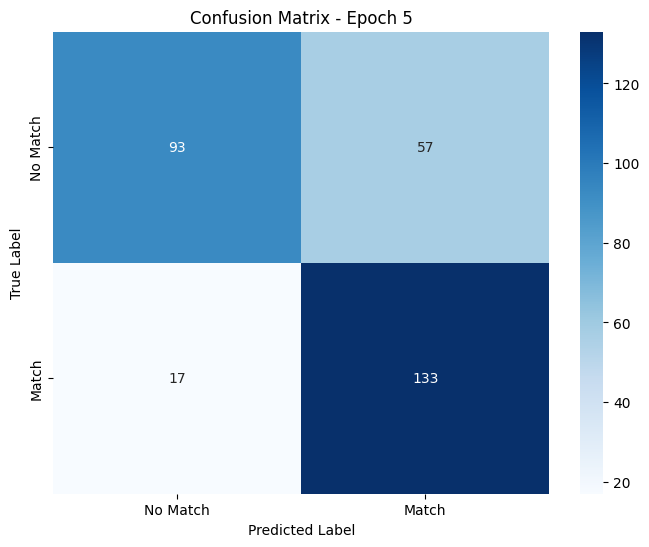


Classification Report - Epoch 5:
              precision    recall  f1-score   support

    No Match       0.85      0.62      0.72       150
       Match       0.70      0.89      0.78       150

    accuracy                           0.75       300
   macro avg       0.77      0.75      0.75       300
weighted avg       0.77      0.75      0.75       300


Epoch 6/25
----------------------------------------


Epoch 6 Testing: 100%|██████████| 10/10 [00:00<00:00, 189.88it/s, Loss=0.4805, Acc=79.67%]


Train - Loss: 0.4947, Acc: 77.20%, Match: 88.43%, No-Match: 66.67%
Test  - Loss: 0.4805, Acc: 79.67%, Match: 88.00%, No-Match: 71.33%

Epoch 7/25
----------------------------------------


Epoch 7 Testing: 100%|██████████| 10/10 [00:00<00:00, 220.44it/s, Loss=0.3871, Acc=83.33%]


Train - Loss: 0.4354, Acc: 81.20%, Match: 92.77%, No-Match: 70.35%
Test  - Loss: 0.3871, Acc: 83.33%, Match: 92.67%, No-Match: 74.00%

Epoch 8/25
----------------------------------------


Epoch 8 Testing: 100%|██████████| 10/10 [00:00<00:00, 225.52it/s, Loss=0.3473, Acc=86.67%]


Train - Loss: 0.3845, Acc: 83.90%, Match: 94.42%, No-Match: 74.03%
Test  - Loss: 0.3473, Acc: 86.67%, Match: 91.33%, No-Match: 82.00%

Epoch 9/25
----------------------------------------


Epoch 9 Testing: 100%|██████████| 10/10 [00:00<00:00, 233.86it/s, Loss=0.3446, Acc=85.00%]


Train - Loss: 0.3676, Acc: 85.40%, Match: 92.77%, No-Match: 78.49%
Test  - Loss: 0.3446, Acc: 85.00%, Match: 92.00%, No-Match: 78.00%

Epoch 10/25
----------------------------------------


Epoch 10 Testing: 100%|██████████| 10/10 [00:00<00:00, 230.58it/s, Loss=0.3782, Acc=86.67%]


Train - Loss: 0.3234, Acc: 86.80%, Match: 97.11%, No-Match: 77.13%
Test  - Loss: 0.3782, Acc: 86.67%, Match: 93.33%, No-Match: 80.00%


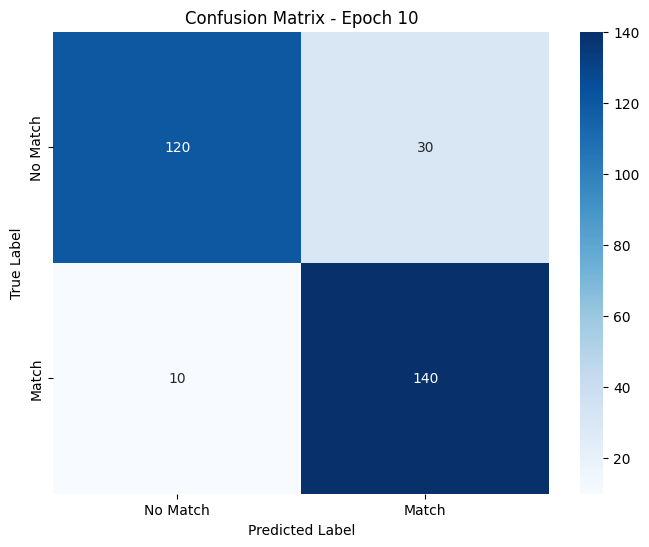


Classification Report - Epoch 10:
              precision    recall  f1-score   support

    No Match       0.92      0.80      0.86       150
       Match       0.82      0.93      0.88       150

    accuracy                           0.87       300
   macro avg       0.87      0.87      0.87       300
weighted avg       0.87      0.87      0.87       300


Epoch 11/25
----------------------------------------


Epoch 11 Testing: 100%|██████████| 10/10 [00:00<00:00, 227.73it/s, Loss=0.3344, Acc=87.67%]


Train - Loss: 0.3124, Acc: 87.40%, Match: 96.49%, No-Match: 78.88%
Test  - Loss: 0.3344, Acc: 87.67%, Match: 92.67%, No-Match: 82.67%

Epoch 12/25
----------------------------------------


Epoch 12 Testing: 100%|██████████| 10/10 [00:00<00:00, 188.12it/s, Loss=0.2891, Acc=90.00%]


Train - Loss: 0.2853, Acc: 90.00%, Match: 97.73%, No-Match: 82.75%
Test  - Loss: 0.2891, Acc: 90.00%, Match: 93.33%, No-Match: 86.67%

Epoch 13/25
----------------------------------------


Epoch 13 Testing: 100%|██████████| 10/10 [00:00<00:00, 183.53it/s, Loss=0.3225, Acc=88.33%]


Train - Loss: 0.3147, Acc: 87.00%, Match: 94.01%, No-Match: 80.43%
Test  - Loss: 0.3225, Acc: 88.33%, Match: 96.00%, No-Match: 80.67%

Epoch 14/25
----------------------------------------


Epoch 14 Testing: 100%|██████████| 10/10 [00:00<00:00, 215.62it/s, Loss=0.2751, Acc=90.00%]


Train - Loss: 0.2839, Acc: 89.80%, Match: 97.31%, No-Match: 82.75%
Test  - Loss: 0.2751, Acc: 90.00%, Match: 93.33%, No-Match: 86.67%

Epoch 15/25
----------------------------------------


Epoch 15 Testing: 100%|██████████| 10/10 [00:00<00:00, 211.58it/s, Loss=0.2640, Acc=90.33%]


Train - Loss: 0.2559, Acc: 90.00%, Match: 94.83%, No-Match: 85.47%
Test  - Loss: 0.2640, Acc: 90.33%, Match: 93.33%, No-Match: 87.33%


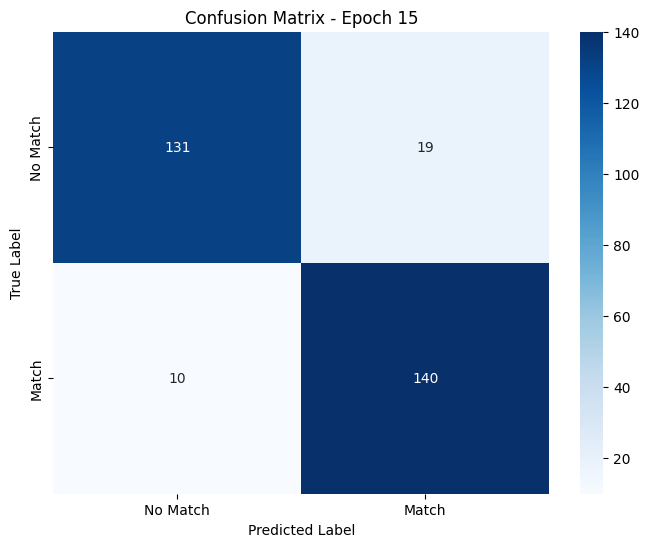


Classification Report - Epoch 15:
              precision    recall  f1-score   support

    No Match       0.93      0.87      0.90       150
       Match       0.88      0.93      0.91       150

    accuracy                           0.90       300
   macro avg       0.90      0.90      0.90       300
weighted avg       0.90      0.90      0.90       300


Epoch 16/25
----------------------------------------


Epoch 16 Testing: 100%|██████████| 10/10 [00:00<00:00, 184.68it/s, Loss=0.3316, Acc=90.33%]


Train - Loss: 0.2112, Acc: 92.30%, Match: 97.31%, No-Match: 87.60%
Test  - Loss: 0.3316, Acc: 90.33%, Match: 92.00%, No-Match: 88.67%

Epoch 17/25
----------------------------------------


Epoch 17 Testing: 100%|██████████| 10/10 [00:00<00:00, 171.42it/s, Loss=0.2883, Acc=92.00%]


Train - Loss: 0.1962, Acc: 93.50%, Match: 96.90%, No-Match: 90.31%
Test  - Loss: 0.2883, Acc: 92.00%, Match: 94.67%, No-Match: 89.33%

Epoch 18/25
----------------------------------------


Epoch 18 Testing: 100%|██████████| 10/10 [00:00<00:00, 189.88it/s, Loss=0.2871, Acc=91.00%]


Train - Loss: 0.1937, Acc: 92.60%, Match: 96.90%, No-Match: 88.57%
Test  - Loss: 0.2871, Acc: 91.00%, Match: 93.33%, No-Match: 88.67%

Epoch 19/25
----------------------------------------


Epoch 19 Testing: 100%|██████████| 10/10 [00:00<00:00, 195.73it/s, Loss=0.2649, Acc=92.67%]


Train - Loss: 0.1810, Acc: 93.60%, Match: 97.52%, No-Match: 89.92%
Test  - Loss: 0.2649, Acc: 92.67%, Match: 94.00%, No-Match: 91.33%

Epoch 20/25
----------------------------------------


Epoch 20 Testing: 100%|██████████| 10/10 [00:00<00:00, 162.63it/s, Loss=0.2690, Acc=93.00%]


Train - Loss: 0.1534, Acc: 94.60%, Match: 98.14%, No-Match: 91.28%
Test  - Loss: 0.2690, Acc: 93.00%, Match: 92.00%, No-Match: 94.00%


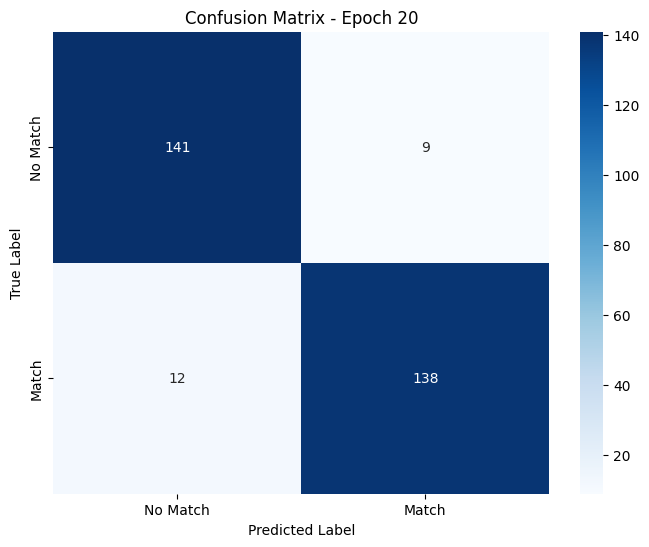


Classification Report - Epoch 20:
              precision    recall  f1-score   support

    No Match       0.92      0.94      0.93       150
       Match       0.94      0.92      0.93       150

    accuracy                           0.93       300
   macro avg       0.93      0.93      0.93       300
weighted avg       0.93      0.93      0.93       300


Epoch 21/25
----------------------------------------


Epoch 21 Testing: 100%|██████████| 10/10 [00:00<00:00, 142.90it/s, Loss=0.2931, Acc=92.33%]


Train - Loss: 0.1302, Acc: 95.70%, Match: 97.52%, No-Match: 93.99%
Test  - Loss: 0.2931, Acc: 92.33%, Match: 93.33%, No-Match: 91.33%

Epoch 22/25
----------------------------------------


Epoch 22 Testing: 100%|██████████| 10/10 [00:00<00:00, 199.66it/s, Loss=0.2952, Acc=94.00%]


Train - Loss: 0.1236, Acc: 96.10%, Match: 98.35%, No-Match: 93.99%
Test  - Loss: 0.2952, Acc: 94.00%, Match: 93.33%, No-Match: 94.67%

Epoch 23/25
----------------------------------------


Epoch 23 Testing: 100%|██████████| 10/10 [00:00<00:00, 204.39it/s, Loss=0.2230, Acc=94.00%]


Train - Loss: 0.1664, Acc: 95.40%, Match: 96.49%, No-Match: 94.38%
Test  - Loss: 0.2230, Acc: 94.00%, Match: 94.67%, No-Match: 93.33%

Epoch 24/25
----------------------------------------


Epoch 24 Testing: 100%|██████████| 10/10 [00:00<00:00, 214.81it/s, Loss=0.2344, Acc=93.67%]


Train - Loss: 0.1103, Acc: 96.80%, Match: 98.14%, No-Match: 95.54%
Test  - Loss: 0.2344, Acc: 93.67%, Match: 94.67%, No-Match: 92.67%

Epoch 25/25
----------------------------------------


Epoch 25 Testing: 100%|██████████| 10/10 [00:00<00:00, 196.24it/s, Loss=0.2840, Acc=92.33%]


Train - Loss: 0.0917, Acc: 97.30%, Match: 98.14%, No-Match: 96.51%
Test  - Loss: 0.2840, Acc: 92.33%, Match: 92.00%, No-Match: 92.67%


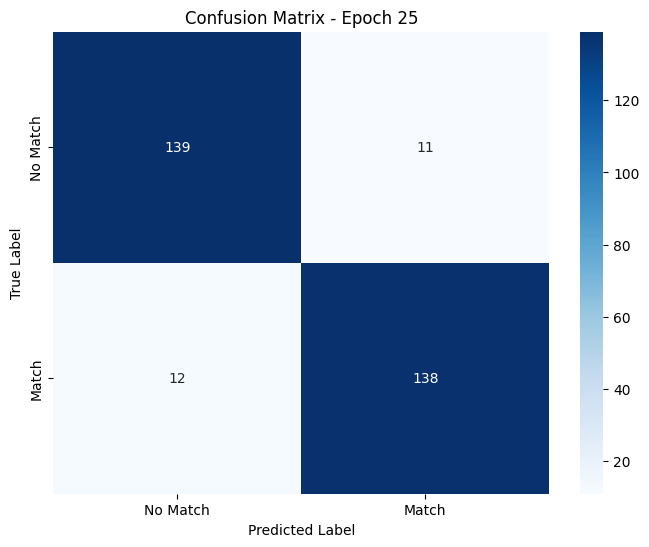


Classification Report - Epoch 25:
              precision    recall  f1-score   support

    No Match       0.92      0.93      0.92       150
       Match       0.93      0.92      0.92       150

    accuracy                           0.92       300
   macro avg       0.92      0.92      0.92       300
weighted avg       0.92      0.92      0.92       300


Training completed in 9.4 seconds


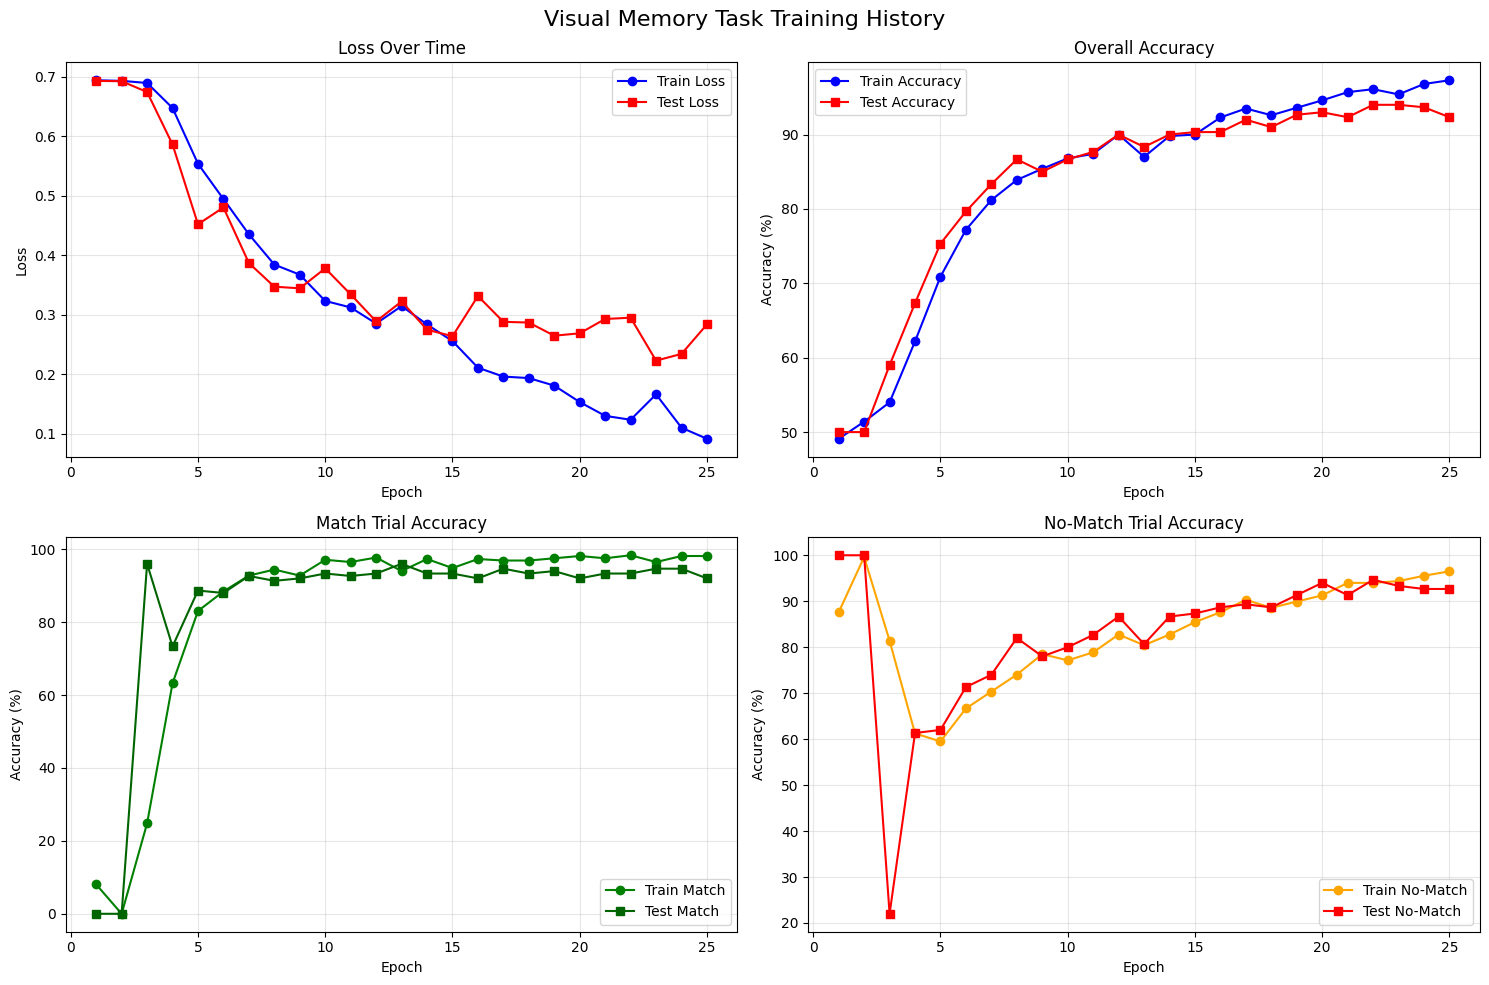


FINAL RESULTS
Best Test Accuracy: 94.00%
Final Test Match Accuracy: 92.00%
Final Test No-Match Accuracy: 92.67%
Training Time: 9.4 seconds


In [ ]:
if __name__ == "__main__":

    print("Visual Memory Task Training Script")
    print("Make sure you have:")
    print("1. Pretrained CNN model: 'mnist_cnn_model.pth'")
    print("2. Visual memory datasets loaded")
    print("\nTo use this script:")
    print("1. Load your datasets using load_saved_datasets()")
    print("2. Call train_visual_memory_model() with your data loaders")


    model, history = train_visual_memory_model(
        train_loader=train_loader,
        test_loader=test_loader,
        test_dataset=test_dataset,
        pretrained_cnn_path='small_cnn_model.pth',
        num_epochs=25,
        learning_rate=0.001,
        save_path='visual_memory_model.pth'
    )
